In [15]:
from abakit.lib.Brain import Brain
import os
from abakit.lib.utilities_registration import register_simple,parameters_to_rigid_transform,rotate_and_align_image,parse_sitk_rigid_transform,find_principle_vector,find_skewness_along_X
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from subprocess import check_output
from scipy.ndimage import affine_transform


In [16]:
def get_rotation_center():
    channel = 1
    INPUT = brain.path.get_thumbnail_cleaned(channel)
    files = sorted(os.listdir(INPUT))
    midpoint = len(files) // 2
    midfilepath = os.path.join(INPUT, files[midpoint])
    width,height = get_image_size(midfilepath)
    center = np.array([width, height]) / 2
    return center

def get_image_size(filepath):
    result_parts = str(check_output(["identify", filepath]))
    results = result_parts.split()
    width, height = results[2].split('x')
    return int(width), int(height)

In [18]:
INPUT = os.path.join(brain.path.prep, 'CH1', 'thumbnail_cleaned')
files = sorted(os.listdir(INPUT))
fixed_index = 194
moving_index = 195
second_transform_parameters,initial_transform_parameters = \
    register_simple(INPUT, fixed_index, moving_index,debug=True)

In [19]:
pixelType = sitk.sitkFloat32
fixed_file = os.path.join(INPUT, f'{fixed_index}.tif')
moving_file = os.path.join(INPUT, f'{moving_index}.tif')
fixed = sitk.ReadImage(fixed_file, pixelType)
moving = sitk.ReadImage(moving_file, pixelType)

In [20]:
fixed = sitk.GetArrayFromImage(fixed)
moving = sitk.GetArrayFromImage(moving)

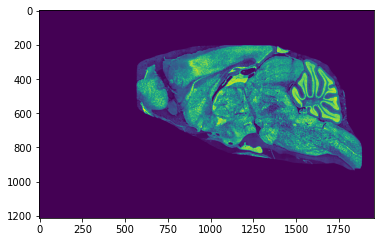

In [21]:
plt.imshow(moving)

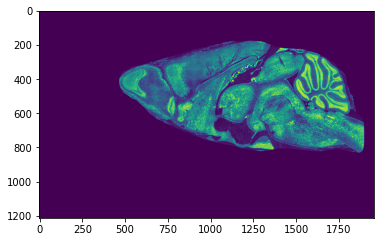

In [22]:
plt.imshow(fixed)

In [10]:
parse_sitk_rigid_transform(initial_transform)

NameError: name 'initial_transform' is not defined

In [ ]:
initial_transform_parameters

(3.124295767226016, -15.0, -42.0, (593.0, 985.0))

In [ ]:
rotation_angle,offset,center_moving = rotate_and_align_image(moving,fixed)
initial_transform = sitk.Euler2DTransform()
initial_transform.SetParameters([rotation_angle,*offset.astype(float)])
initial_transform.SetFixedParameters(center_moving.astype(float))
print(initial_transform)

itk::simple::Euler2DTransform
 Euler2DTransform (0x5e85a70)
   RTTI typeinfo:   itk::Euler2DTransform<double>
   Reference Count: 1
   Modified Time: 132389
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     -0.99985 -0.017296 
     0.017296 -0.99985 
   Offset: [1187.95, 1917.6]
   Center: [593, 985]
   Translation: [-15, -42]
   Inverse: 
     -0.99985 0.017296 
     -0.017296 -0.99985 
   Singular: 0
   Angle       = 3.1243



In [12]:
T1 = parameters_to_rigid_transform(*initial_transform_parameters)
T2 = parameters_to_rigid_transform(*second_transform_parameters, get_rotation_center())
T = T1@T2     
# xshift,yshift,rotation,_ = brain.rigid_transform_to_parmeters(T)      

In [13]:
Tapp = T
image1 = affine_transform(moving,Tapp[:2,:2],Tapp[:2,2])

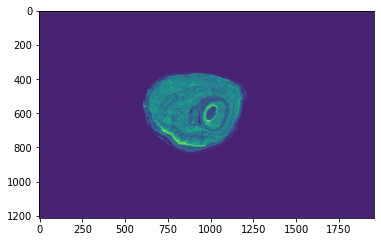

In [14]:
plt.imshow(image1)

In [73]:
moving_mask = np.array((np.array(moving)>np.mean(moving))*255).astype('uint8')
fixed_mask = np.array((np.array(fixed)>np.mean(fixed))*255).astype('uint8')
theta_moving,center_moving = find_principle_vector(moving_mask)
theta_fixed,center_fixed = find_principle_vector(fixed_mask)
T = parameters_to_rigid_transform(rotation = -theta_moving,xshift=0,yshift=0,center=np.flip(center_moving))
straight_moving = affine_transform(moving,T)
T = parameters_to_rigid_transform(rotation = -theta_fixed,xshift=0,yshift=0,center=np.flip(center_fixed))
straight_fixed = affine_transform(fixed,T)
skewness_moving = find_skewness_along_X(straight_moving)
skewness_fixed = find_skewness_along_X(straight_fixed)


In [70]:
if np.sign(skewness_fixed) != np.sign(skewness_moving):
    theta_moving = (theta_moving+np.pi)%(2*np.pi)
rotation_angle = theta_fixed-theta_moving
offset = center_fixed - center_moving
rotation_angle = (theta_fixed-theta_moving)%(2*np.pi)

In [75]:
skewness_fixed,skewness_moving

(0.05352770401056967, -0.01202805314404994)

In [77]:
theta_fixed

0.1824455784997631

In [78]:
theta_moving

0.19974246486354014

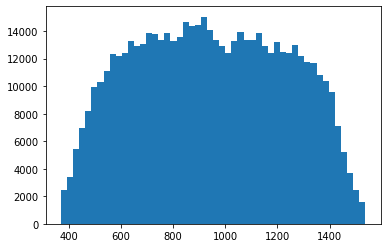

In [85]:
inds = np.argwhere(fixed>np.mean(fixed))
plt.hist(inds[:,1],bins = 50);

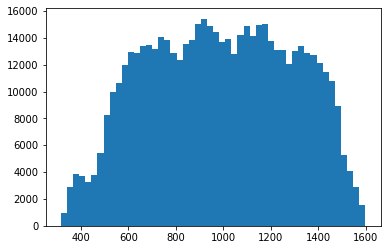

In [86]:
inds = np.argwhere(moving>np.mean(moving))
plt.hist(inds[:,1],bins = 50);